# Setup

In [56]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, fbeta_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.svm import SVC

#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation
#import keras.backend as K
#from keras.optimizers import SGD, Adam

#from brew.base import Ensemble, EnsembleClassifier
#from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
#from brew.combination.combiner import Combiner

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


# Data pre process

In [2]:
dt_path = "../data/kdd2009/"

In [3]:
#first 190 features are numerical and the last 40 are categorical
X = pd.read_table(dt_path+"orange_small_train.data")
X.shape

(50000, 230)

## features transformation

In [4]:
num_features = list(X.columns[:190])
cat_features = list(X.columns[190:230])

In [5]:
empty_features = []
c = 0.3
for feat in X.columns:
    nulls = X[feat].isnull().value_counts()
    try:
        not_nulls = nulls[False]
        if not_nulls < c*40000:
            empty_features.append(feat)
    except:    
        empty_features.append(feat)
print ("number of empty features is", len(empty_features))

number of empty features is 154


In [6]:
#remove sparse features
for feat in empty_features:
    #data.drop(feat, axis = 1, inplace = True)    
    if feat in num_features:
        num_features.remove(feat)
    else:
        cat_features.remove(feat)
    X.drop(feat,axis=1, inplace=True)

## missing value imputation

In [7]:
#Numeric features: replace missing values with (max value + 1).
maxs = X.max(axis = 0)
for i,feat in enumerate(num_features):
    fill_value = maxs[i] + 1.
    X.fillna({feat: fill_value}, inplace=True)

In [8]:
#Categorial features: replace values with their frequencies.
data_cat_all = X[cat_features]

for feat in data_cat_all.columns:
    data_cat_all[feat] = data_cat_all[feat].map(data_cat_all.groupby(feat).size())
    
X[cat_features] = data_cat_all.loc[:39999,:]

In [9]:
#Categorial features: replace missing values with zeros.
X.fillna(0., inplace=True)

## Load target valuable

In [10]:
y = pd.read_table(dt_path+"orange_small_train_churn.labels",header=None)
y.shape

(50000, 1)

In [11]:
y = LabelEncoder().fit_transform(y)

In [12]:
pd.Series(y).value_counts() 

0    46328
1     3672
dtype: int64

## get data ready for training

In [57]:
Scaler = MinMaxScaler()
X = pd.DataFrame(Scaler.fit_transform(X),columns=X.columns,index=X.index)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2018, stratify=y)

# Modeling

## Single Light GBM model

In [14]:
lgb_params = {'max_depth': 10, 'learning_rate': 0.01, 'random_state': 2018, 'cat_features':cat_features}
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt',
        cat_features=['Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var214', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229'],
        colsample_bytree=1.0, learning_rate=0.01, max_bin=255,
        max_depth=10, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
        objective=None, random_state=2018, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [15]:
y_pred_proba = lgb.predict_proba(X_test)[:, 1]

In [16]:
recall_score(y_test, lgb.predict(X_test))

0.013623978201634877

In [17]:
roc_auc_score(y_test, y_pred_proba)

0.7123242453880496

## Multi Models

In [18]:
import sys
sys.path.append('../src/model')
from model_training_eval import model_training_eval

In [19]:
SEED = 2018
MAX_DEPTH = [5,10,15]
LEARNING_RATE = [0.01,0.05,0.1]

In [20]:
gbm_params = {
#    'n_estimators': [100],
    'max_depth': MAX_DEPTH,
    'learning_rate': LEARNING_RATE,
    'random_state': [SEED]
}

In [21]:
xgb_params = {
    'max_depth': MAX_DEPTH,
    'learning_rate': LEARNING_RATE,
    'seed':[SEED]
}

In [22]:
catb_params = {
    'iterations': [100],
    'learning_rate': LEARNING_RATE,
    'depth': MAX_DEPTH,
}

In [23]:
lgb_params = {'max_depth': MAX_DEPTH, 'learning_rate': LEARNING_RATE}

In [24]:
classifiers = [
    (GradientBoostingClassifier(n_estimators=100), gbm_params),
    (LogisticRegression(), None),
    (RandomForestClassifier(n_estimators = 1000), None),
    #(KNeighborsClassifier(),None),
    (XGBClassifier(), xgb_params),
    (CatBoostClassifier(loss_function='Logloss'), catb_params),
    (LGBMClassifier(cat_features=cat_features), lgb_params),
    (GaussianNB(), None),
    (QuadraticDiscriminantAnalysis(), None),
#    (SVC(kernel="poly"), None) removed due to training time 
]

In [25]:
modeling = model_training_eval(classifiers, X_train, X_test, y_train, y_test)

In [26]:
eva = modeling.get_performance()

GradientBoostingClassifier is finished after 1:17:55.044514 HPT. 
The execution time of the best model is 0:00:31.495244.

LogisticRegression is finished after 0:00:00.000002 HPT. 
The execution time of the best model is 0:00:08.533126.

RandomForestClassifier is finished after 0:00:00.000002 HPT. 
The execution time of the best model is 0:02:02.751735.

XGBClassifier is finished after 0:01:15.712998 HPT. 
The execution time of the best model is 0:00:01.925750.

CatBoostClassifier is finished after 0:47:59.359263 HPT. 
The execution time of the best model is 0:00:04.851712.

LGBMClassifier is finished after 0:00:06.096241 HPT. 
The execution time of the best model is 0:00:00.222621.

GaussianNB is finished after 0:00:00.000004 HPT. 
The execution time of the best model is 0:00:00.102074.

QuadraticDiscriminantAnalysis is finished after 0:00:00.000003 HPT. 
The execution time of the best model is 0:00:00.125428.



## Model Performance

### Summary

In [27]:
modeling.get_models()

[GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=5,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=2018, subsample=1.0, verbose=0,
               warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min

### Performance

In [28]:
eva

,roc_auc_score,precision_score,recall_score,fbeta_score,execusion_time,hpt_time
GradientBoostingClassifier,0.749561,0.533333,0.0217984,0.0269724,0:00:31.495244,1:17:55.044514
LogisticRegression,0.60053,0.111111,0.0013624,0.00169779,0:00:08.533126,0:00:00.000002
RandomForestClassifier,0.714479,0,0,0,0:02:02.751735,0:00:00.000002
XGBClassifier,0.750891,0.785714,0.0149864,0.0186441,0:00:01.925750,0:01:15.712998
CatBoostClassifier,0.749957,0.444444,0.00544959,0.00679117,0:00:04.851712,0:47:59.359263
LGBMClassifier,0.722152,0,0,0,0:00:00.222621,0:00:06.096241
GaussianNB,0.600302,0.0803583,0.855586,0.292066,0:00:00.102074,0:00:00.000004
QuadraticDiscriminantAnalysis,0.635657,0.106973,0.583106,0.308491,0:00:00.125428,0:00:00.000003


### ROC Performance Comparison 

In [29]:
pred_names, pred_classes, pred_probs = modeling.get_predictions()

In [30]:
#calculate true positive and false positive
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(modeling.pred_proba)):
    fpr[i], tpr[i], _ = roc_curve(y_test,modeling.pred_proba[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

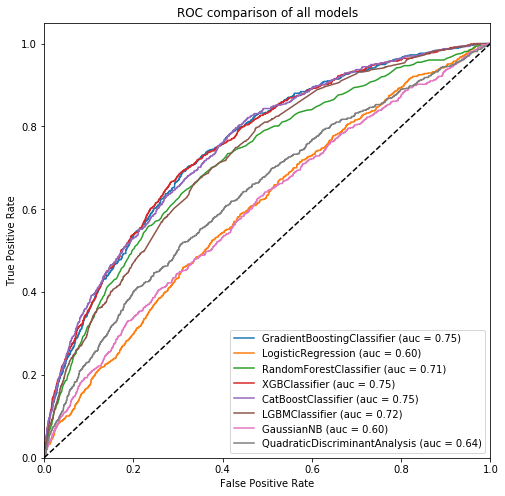

In [31]:
plt.figure(figsize=(8,8))
for i in range(len(modeling.pred_proba)):
    plt.plot(
        fpr[i],
        tpr[i],
        label='{0} (auc = {1:0.2f})'
        ''.format(modeling.cls_name[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison of all models')
plt.legend(loc="lower right")
plt.show()

### probability distributions

In [32]:
#probability distributions of different models
results = pd.DataFrame(modeling.pred_proba,index=modeling.cls_name).T
results.describe()

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier,GaussianNB,QuadraticDiscriminantAnalysis
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,0.073692,0.085331,0.085234,0.076125,0.073275,0.225218,7.170831e-01,0.400847
std,0.064942,0.066179,0.059583,0.058141,0.056725,0.030397,3.750229e-01,0.400490
min,0.009576,0.000264,0.000000,0.007828,0.005921,0.182427,3.567625e-23,0.000000
25%,0.035270,0.039199,0.043000,0.039126,0.036251,0.203082,6.447334e-01,0.006410
50%,0.056561,0.066845,0.071000,0.063358,0.059476,0.222429,9.278320e-01,0.232729
75%,0.088315,0.111608,0.113000,0.093861,0.091764,0.236594,9.678626e-01,0.850849
max,0.900925,0.825871,0.467000,0.677832,0.650857,0.469779,9.999901e-01,1.000000


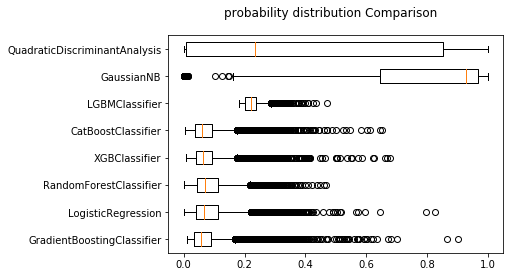

In [33]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('probability distribution Comparison')
ax = fig.add_subplot(111)
plt.boxplot(modeling.pred_proba,vert=False)
ax.set_yticklabels(modeling.cls_name)
plt.show()

# Probability Calibration

## plot

In [34]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [35]:
axis_x = dict()
axis_y = dict()
for i in range(len(modeling.pred_proba)):
    axis_y[i], axis_x[i] = calibration_curve(y_test, modeling.pred_proba[i], n_bins=10)

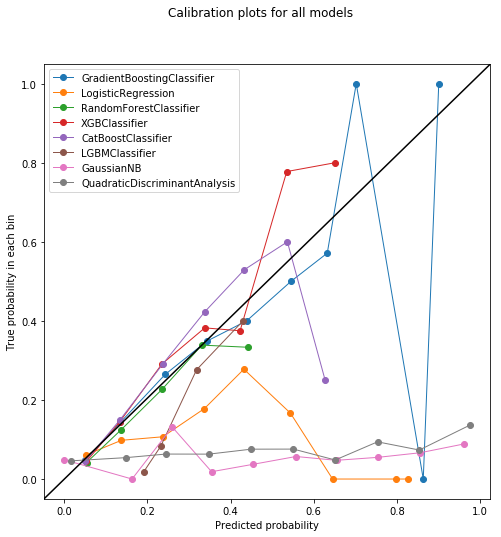

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(8, 8))
for i in range(len(modeling.pred_proba)):
    plt.plot(
        axis_x[i],
        axis_y[i],
        marker='o',
        linewidth=1,
        label=modeling.cls_name[i])

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plots for all models')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

## calibrate

### xgb

In [37]:
xgb_best_params = modeling.get_models()[3].get_params()

In [38]:
xgb_best = XGBClassifier(**xgb_best_params)
isotonic = CalibratedClassifierCV(xgb_best, cv=2, method='isotonic')
sigmoid = CalibratedClassifierCV(xgb_best, cv=2, method='sigmoid')

In [39]:
names_cali = ['xgb','xgb_isotonic','xgb_sigmoid']

In [40]:
y_pred_cal = []
for cls in [xgb_best,isotonic,sigmoid]:
    cls.fit(X_train,y_train)
    y_pred_cal.append(cls.predict_proba(X_test)[:, 1])    

In [41]:
axis_x = dict()
axis_y = dict()
for i in range(3):
    axis_y[i], axis_x[i] = calibration_curve(y_test, y_pred_cal[i], n_bins=10)

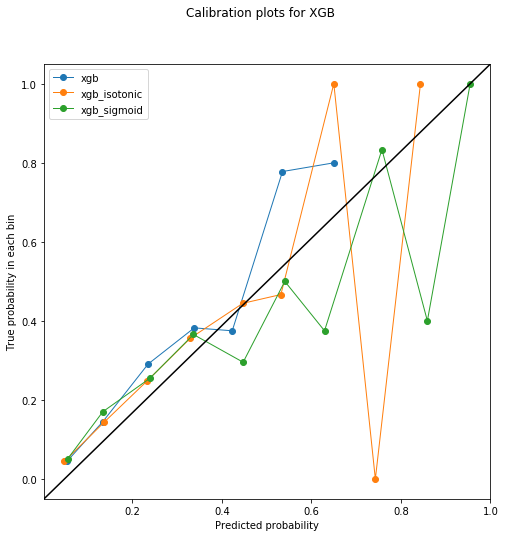

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(8, 8))
for i in range(3):
    plt.plot(
        axis_x[i],
        axis_y[i],
        marker='o',
        linewidth=1,
        label=names_cali[i])

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plots for XGB')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

# Ensembling

## Mean

In [43]:
prob_avg = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].mean(axis=1)

roc_auc_score(y_test, prob_avg)

0.7525109377049257

## Minimum

In [44]:
prob_min = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].min(axis=1)

roc_auc_score(y_test, prob_min)

0.7502298844152627

## Maximum

In [45]:
prob_max = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].max(axis=1)

roc_auc_score(y_test, prob_max)

0.7273959734425055

## Median

In [46]:
prob_median = results[[
    'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier',
    'LGBMClassifier'
]].median(axis=1)

roc_auc_score(y_test, prob_median)

0.7539345743219916

# Stacking

In [47]:
from Stacking import Stacking

## Model

In [48]:
xgb_best_params = modeling.get_models()[3].get_params()
xgb_best = XGBClassifier(**xgb_best_params)

lgb_best_params = modeling.get_models()[5].get_params()
lgb_best = LGBMClassifier(**lgb_best_params)

rf_best = RandomForestClassifier(n_estimators = 1000)

log_model = LogisticRegression()

In [49]:
stack = Stacking(
    n_splits=3, stacker=log_model, base_models=(xgb_best, lgb_best, rf_best))

y_pred_stack = stack.fit_predict(X_train, y_train, X_test)

inside
Fit XGBClassifier fold 1
Fit XGBClassifier fold 2
Fit XGBClassifier fold 3
Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit RandomForestClassifier fold 1
Fit RandomForestClassifier fold 2
Fit RandomForestClassifier fold 3
Stacker score: 0.72027


## Performance

In [50]:
roc_auc_score(y_test, y_pred_stack)

0.7492942467583871

## Probability Calibration 

In [51]:
ensemble_preds = [prob_avg,prob_min,prob_max,prob_median,y_pred_stack]
ensemble_names = ['prob_avg','prob_min','prob_max','prob_median','y_pred_stack']

In [52]:
axis_x = dict()
axis_y = dict()
for i in range(len(ensemble_preds)):
    axis_y[i], axis_x[i] = calibration_curve(y_test, ensemble_preds[i], n_bins=10)

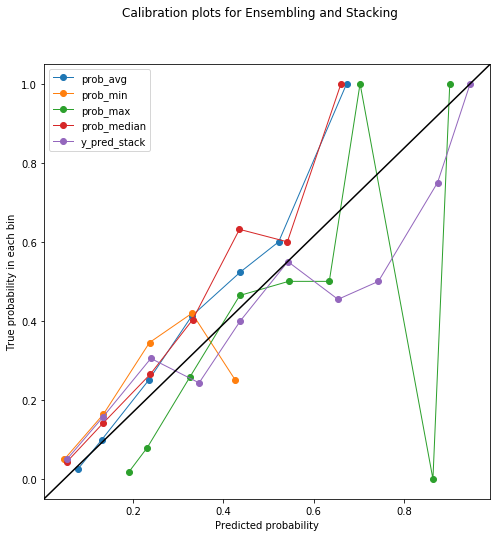

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(8, 8))
for i in range(len(ensemble_preds)):
    plt.plot(
        axis_x[i],
        axis_y[i],
        marker='o',
        linewidth=1,
        label=ensemble_names[i])

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plots for Ensembling and Stacking')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()